#   Data

In [3]:
#Paths to data
train_path= '/kaggle/input/kermany2018/OCT2017 /train/'
val_path= '/kaggle/input/kermany2018/OCT2017 /val/'
test_path= '/kaggle/input/kermany2018/OCT2017 /test/'


# Import Libraries

In [4]:
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import os
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, ReLU
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
import itertools

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Preprocessing

In [5]:
#Calculate class weight for the imbalanced data
total = 83484

count_cnv = 37205
count_dme = 11348
count_drusen = 8616
count_normal = 26315

cnv_weight = (1/count_cnv) * (total/4)
dme_weight = (1/count_dme) * (total/4)
drusen_weight = (1/count_drusen) * (total/4)
norm_weight = (1/count_normal) * (total/4)

class_weight = {0 : cnv_weight, 1: dme_weight, 2 : drusen_weight, 3: norm_weight}
print(class_weight)


labels = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

def load(path):
    listed_paths = []
    for i in labels:
        base_path = os.path.join(path, i)
        imgs = os.listdir(base_path)
        for img in imgs:
            img_path = base_path + '/' + img
            listed_paths.append(img_path)
    return listed_paths

train_paths = load(train_path)
val_paths = load(val_path)
test_paths = load(test_path)


{0: 0.5609729875016799, 1: 1.839178709904829, 2: 2.4223537604456826, 3: 0.7931217936538096}


# Data augmentation

In [6]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2,
        
    )

In [7]:
val_datagen = ImageDataGenerator(
    rescale=1./255
)

In [8]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
# Set batch size
batch_size = 32

# Set image size
img_size = (224, 224)

In [10]:
image_paths = []
labels = []
for class_name in os.listdir(train_path):
    class_path = os.path.join(train_path, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image_paths.append(image_path)
        labels.append(class_name)

In [11]:
# Split the image file paths into training and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

In [12]:
# Create a DataFrame with the image file paths and labels
train_data_df = pd.DataFrame({'filename': train_paths, 'class': train_labels})

In [13]:
# Create the data generators
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data_df,
    x_col='filename',
    y_col='class',
    batch_size=batch_size,
    target_size=img_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

Found 66787 validated image filenames belonging to 4 classes.


In [14]:
val_data_df = pd.DataFrame({'filename': val_paths, 'class': val_labels})
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data_df,
    x_col='filename',
    y_col='class',
    batch_size=batch_size,
    target_size=img_size,
    class_mode='categorical',
    shuffle=False,
)

Found 16697 validated image filenames belonging to 4 classes.


In [15]:
test_generator = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 968 images belonging to 4 classes.


# Show sample

Train has 66787 images
Validation has 16697 images
test has 968 images


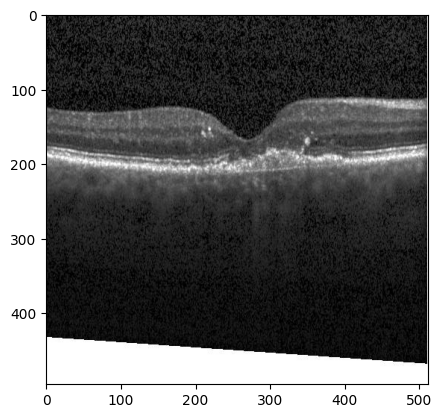

In [20]:
#Sample
print("Train has " + str(len(train_paths)) + " images")
img1 = cv2.imread(train_paths[8000])
plt.imshow(img1)

print("Validation has " + str(len(val_paths)) + " images")

print("test has " + str(len(test_paths)) + " images")


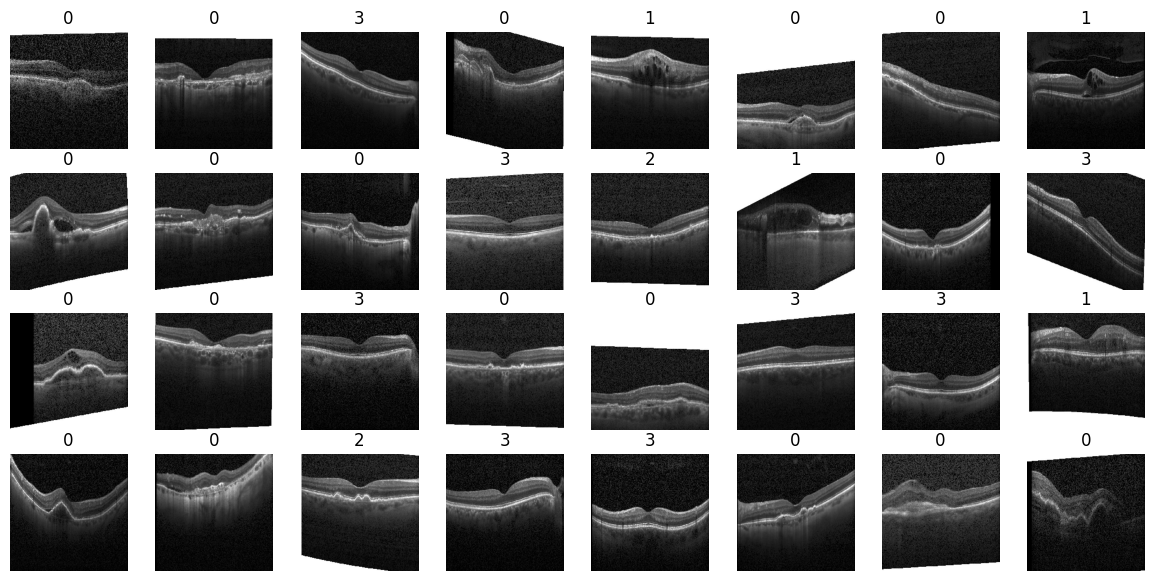

In [21]:
#data samples
batch_images, batch_labels = train_generator.next()

fig, axs = plt.subplots(4, 8, figsize=(15, 7))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(32):
    axs[i].imshow(batch_images[i])
    axs[i].set_title(np.argmax(batch_labels[i]))
    axs[i].axis('off')
plt.show()

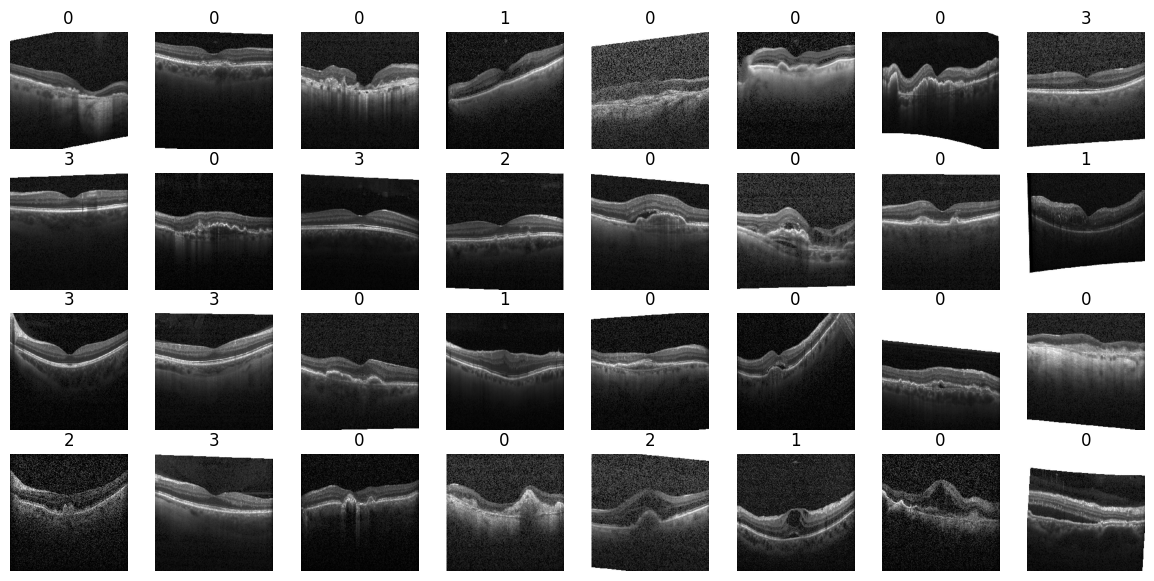

In [22]:
batch_images, batch_labels = val_generator.next()

fig, axs = plt.subplots(4, 8, figsize=(15, 7))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(32):
    axs[i].imshow(batch_images[i])
    axs[i].set_title(np.argmax(batch_labels[i]))
    axs[i].axis('off')
plt.show()

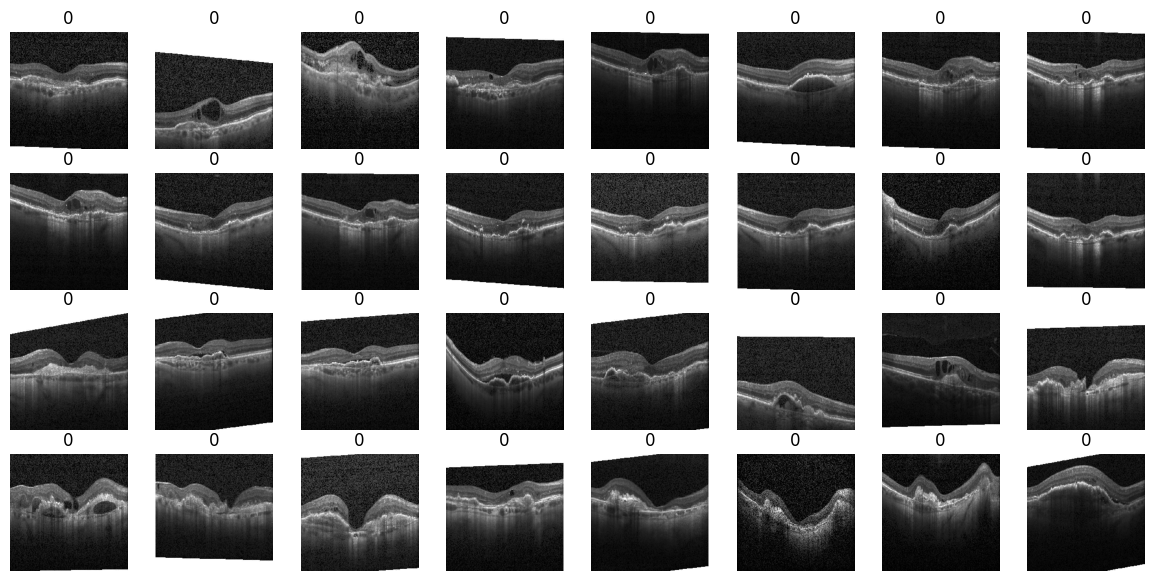

In [23]:
batch_images, batch_labels = test_generator.next()

fig, axs = plt.subplots(4, 8, figsize=(15, 7))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(32):
    axs[i].imshow(batch_images[i])
    axs[i].set_title(np.argmax(batch_labels[i]))
    axs[i].axis('off')
plt.show()

# Build the Model inceptionV3

In [33]:
# Set hyperparameters
img_width, img_height = 224, 224
batch_size = 32
epochs = 30
img_size = (224, 224)
# Get the number of classes
num_classes = len(train_generator.class_indices)

In [34]:
# Create the base InceptionV3 model with imagenet weights and without the top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [35]:
# Freeze the weights of the pre-trained layers in the base model
for layer in base_model.layers:
    layer.trainable = False

In [36]:
# Add new layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [37]:
# base_model.summary()

In [38]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [39]:
# Compile the model with Adam optimizer
opt = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# Set callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=1e-7)

In [40]:
plot_model(model, to_file='InceptionV3.png', show_shapes=True)

In [41]:
# Train the model with data generators and callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=(train_generator.samples // batch_size) // 2 ,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/30
1043/1043 [==============================] - 218s 205ms/step - loss: 0.5026 - accuracy: 0.8171 - val_loss: 0.4204 - val_accuracy: 0.8466 - lr: 1.0000e-04
Epoch 2/30
1043/1043 [==============================] - 201s 193ms/step - loss: 0.4084 - accuracy: 0.8540 - val_loss: 0.3944 - val_accuracy: 0.8537 - lr: 1.0000e-04
Epoch 3/30
1043/1043 [==============================] - 205s 196ms/step - loss: 0.3800 - accuracy: 0.8641 - val_loss: 0.3823 - val_accuracy: 0.8636 - lr: 1.0000e-04
Epoch 4/30
1043/1043 [==============================] - 207s 199ms/step - loss: 0.3568 - accuracy: 0.8729 - val_loss: 0.3673 - val_accuracy: 0.8703 - lr: 1.0000e-04
Epoch 5/30
1043/1043 [==============================] - 201s 193ms/step - loss: 0.3466 - accuracy: 0.8771 - val_loss: 0.3752 - val_accuracy: 0.8627 - lr: 1.0000e-04
Epoch 6/30
1043/1043 [==============================] - 227s 218ms/step - loss: 0.3298 - accuracy: 0.8816 - val_loss: 0.3454 - val_accuracy: 0.8772 - lr: 1.0000e-04
Epoch 7/30

In [42]:
# Save the model
model.save('InceptionV3.h5')

# Charts

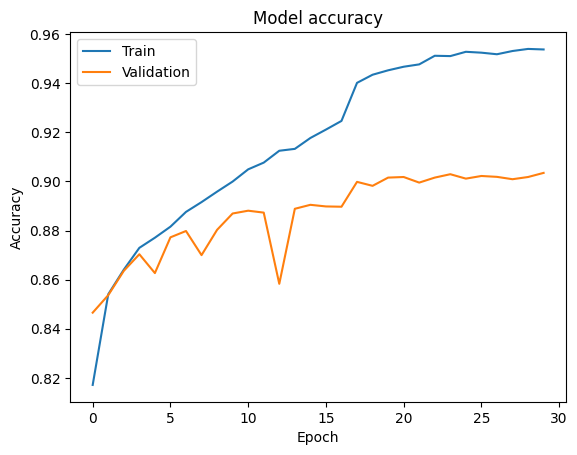

In [44]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

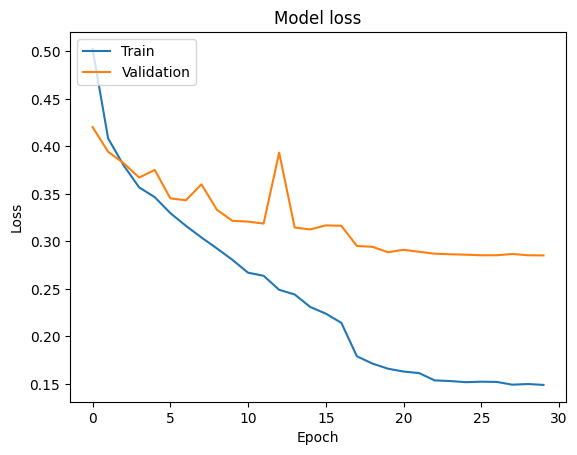

In [45]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

522/522 [==============================] - 69s 132ms/step


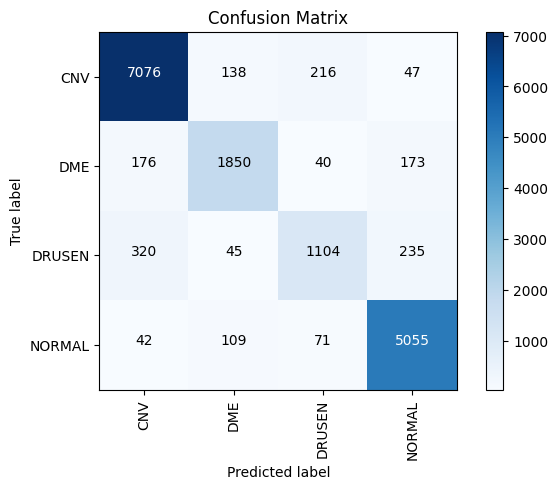

In [49]:
# Calculate the predictions on the validation set
val_generator.reset()
y_pred = model.predict(val_generator, steps=len(val_generator))
y_pred = np.argmax(y_pred, axis=1)

# Get the true labels for the validation set
y_true = val_generator.classes

# Calculate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(val_generator.class_indices))
plt.xticks(tick_marks, val_generator.class_indices, rotation=90)
plt.yticks(tick_marks, val_generator.class_indices)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


## Calculate the Accuracy

In [50]:
# Predict probabilities for test set
test_probabilities = model.predict(test_generator)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_generator.classes == i, test_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute Precision-Recall curve and AUC for each class
precision = dict()
recall = dict()
pr_auc = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(test_generator.classes == i, test_probabilities[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

31/31 [==============================] - 4s 122ms/step


In [51]:
# Compute f1 score for each class
f1_scores = dict()
for i in range(num_classes):
    y_true = test_generator.classes == i
    y_pred = test_probabilities.argmax(axis=1) == i
    f1_scores[i] = f1_score(y_true, y_pred)

## Make ROC and Precision-Recall curve

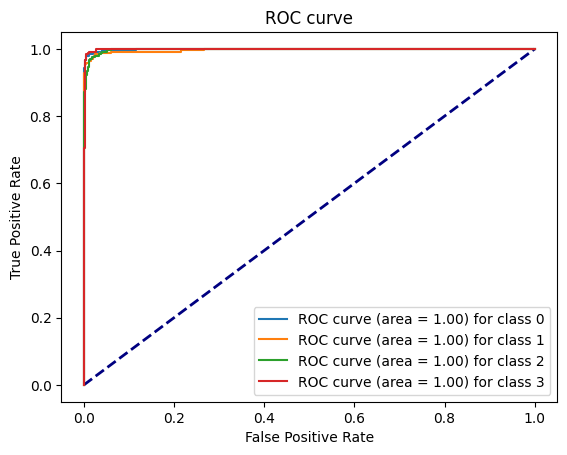

In [52]:
# Plot ROC curve
plt.figure()
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

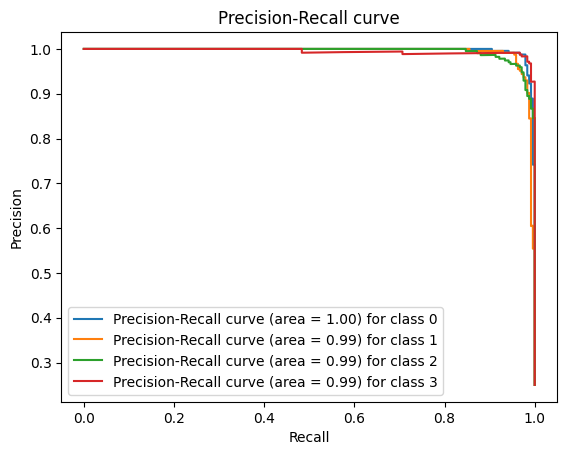

In [53]:
# Plot Precision-Recall curve
plt.figure()
for i in range(num_classes):
    plt.plot(recall[i], precision[i], label='Precision-Recall curve (area = %0.2f) for class %d' % (pr_auc[i], i))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()

In [54]:
# Calculate the predictions on the validation set
val_generator.reset()
y_pred = model.predict(val_generator, steps=len(val_generator))
y_pred = np.argmax(y_pred, axis=1)

522/522 [==============================] - 66s 127ms/step


In [55]:
# calculate precision, recall, f1-score, and support for each class
class_report = classification_report(val_generator.classes, y_pred, target_names=val_generator.class_indices.keys())
print(class_report)

              precision    recall  f1-score   support

         CNV       0.93      0.95      0.94      7477
         DME       0.86      0.83      0.84      2239
      DRUSEN       0.77      0.65      0.70      1704
      NORMAL       0.92      0.96      0.94      5277

    accuracy                           0.90     16697
   macro avg       0.87      0.84      0.86     16697
weighted avg       0.90      0.90      0.90     16697



In [56]:
# Evaluate the model on the train generator
train_loss, train_acc = sum(history.history['loss'])/len(history.history['loss']),sum(history.history['accuracy'])/len(history.history['accuracy'])
print("Train accuracy:", train_acc)
print("Train loss:", train_loss)
print(80 * '_')

# Evaluate the model on the validation generator
val_loss, val_acc = model.evaluate(val_generator, verbose=0)
print("Validation accuracy:", val_acc)
print("Validation loss:", val_loss)
print(80 * '_')

# Evaluate the model on the test generator
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

Train accuracy: 0.9162018597126007
Train loss: 0.2421224201718966
________________________________________________________________________________
Validation accuracy: 0.9034557342529297
Validation loss: 0.2852896749973297
________________________________________________________________________________
Test accuracy: 0.9545454382896423
Test loss: 0.12928970158100128


# evaluate the third model on the test data

In [57]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)

# Make predictions on the test set
test_generator.reset()
y_pred = model.predict(test_generator, verbose=1)
predictions = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Compute the precision, recall, and f1 score
print(classification_report(y_true, predictions))

31/31 [==============================] - 3s 111ms/step
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       242
           1       0.99      0.95      0.97       242
           2       0.98      0.89      0.93       242
           3       0.96      0.98      0.97       242

    accuracy                           0.95       968
   macro avg       0.96      0.95      0.95       968
weighted avg       0.96      0.95      0.95       968

